# 3. Ứng Dụng Demo: Nhận Dạng Chữ Số Viết Tay

Ứng dụng này cho phép người dùng vẽ chữ số hoặc tải ảnh lên, sau đó sử dụng mô hình PCA + SoftmaxRegression để dự đoán chữ số. Kết quả hiển thị xác suất cho mỗi chữ số từ 0-9.

## Phần 1: Nhập thư viện & Load mô hình

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os

# Thêm đường dẫn thư viện
sys.path.insert(0, '../lib')
from SoftmaxRegression import SoftmaxRegression

print("✓ Thư viện đã nhập thành công")

# Load mô hình PCA + SoftmaxRegression đã huấn luyện
model_path = '../models/best_model_weights.npz'

# Load trọng số
if os.path.exists(model_path):
    model_data = np.load(model_path)
    pca_mean = model_data['pca_mean']
    pca_vt = model_data['pca_vt']
    pca_n_components = int(model_data['pca_n_components'])
    model_weights = model_data['model_weights']
    model_bias = model_data['model_bias']
    
    # Khởi tạo mô hình và load trọng số
    model = SoftmaxRegression(n_features=pca_n_components, n_classes=10, learning_rate=0.05)
    model.W = model_weights
    model.b = model_bias
    
    print(f"✓ Mô hình đã load thành công")
    print(f"  - PCA Components: {pca_n_components}")
    print(f"  - Model Shape W: {model.W.shape}")
    print(f"  - Model Shape b: {model.b.shape}")
else:
    print(f"✗ Không tìm thấy file mô hình: {model_path}")
    print(f"  Vui lòng chạy notebook 2_Feature_Experiments.ipynb trước")

✓ Thư viện đã nhập thành công
✓ Mô hình đã load thành công
  - PCA Components: 80
  - Model Shape W: (80, 10)
  - Model Shape b: (1, 10)
✓ Mô hình đã load thành công
  - PCA Components: 80
  - Model Shape W: (80, 10)
  - Model Shape b: (1, 10)


## Phần 2: Hàm hỗ trợ xử lý ảnh & dự đoán

In [3]:
def preprocess_image(img_array, target_size=28):
    """
    Tiền xử lý ảnh: resize về 28x28 và chuẩn hóa về [0, 1]
    """
    # Chuyển sang ảnh xám nếu là RGB
    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        img_gray = np.mean(img_array, axis=2)
    else:
        img_gray = img_array
    
    # Resize về 28x28
    from PIL import Image
    img_pil = Image.fromarray((img_gray * 255).astype(np.uint8))
    img_pil = img_pil.resize((target_size, target_size), Image.LANCZOS)
    img_resized = np.array(img_pil) / 255.0
    
    return img_resized

def apply_pca(img_flat, pca_mean, pca_vt):
    """
    Áp dụng PCA transform lên ảnh đã flatten
    """
    img_centered = img_flat - pca_mean
    img_pca = img_centered @ pca_vt.T
    return img_pca

def predict_digit(img_array, model, pca_mean, pca_vt):
    """
    Dự đoán chữ số từ ảnh
    
    Args:
        img_array: Ảnh input (có thể là 28x28 hoặc bất kỳ kích thước nào)
        model: Mô hình SoftmaxRegression đã train
        pca_mean: PCA mean vector
        pca_vt: PCA eigenvectors
    
    Returns:
        dict: Chứa dự đoán, xác suất, và các thống kê
    """
    # Tiền xử lý
    img_processed = preprocess_image(img_array)
    img_flat = img_processed.flatten()
    
    # Áp dụng PCA
    img_pca = apply_pca(img_flat, pca_mean, pca_vt)
    
    # Dự đoán
    y_proba = model.predict_proba(img_pca.reshape(1, -1))[0]
    y_pred = np.argmax(y_proba)
    confidence = y_proba[y_pred]
    
    return {
        'prediction': y_pred,
        'confidence': confidence,
        'probabilities': y_proba,
        'preprocessed_image': img_processed
    }

print("✓ Các hàm hỗ trợ đã được định nghĩa")

✓ Các hàm hỗ trợ đã được định nghĩa


## Phần 3: Demo 1 - Tải ảnh từ test set và dự đoán

✓ MNIST test set loaded: (10000, 28, 28)


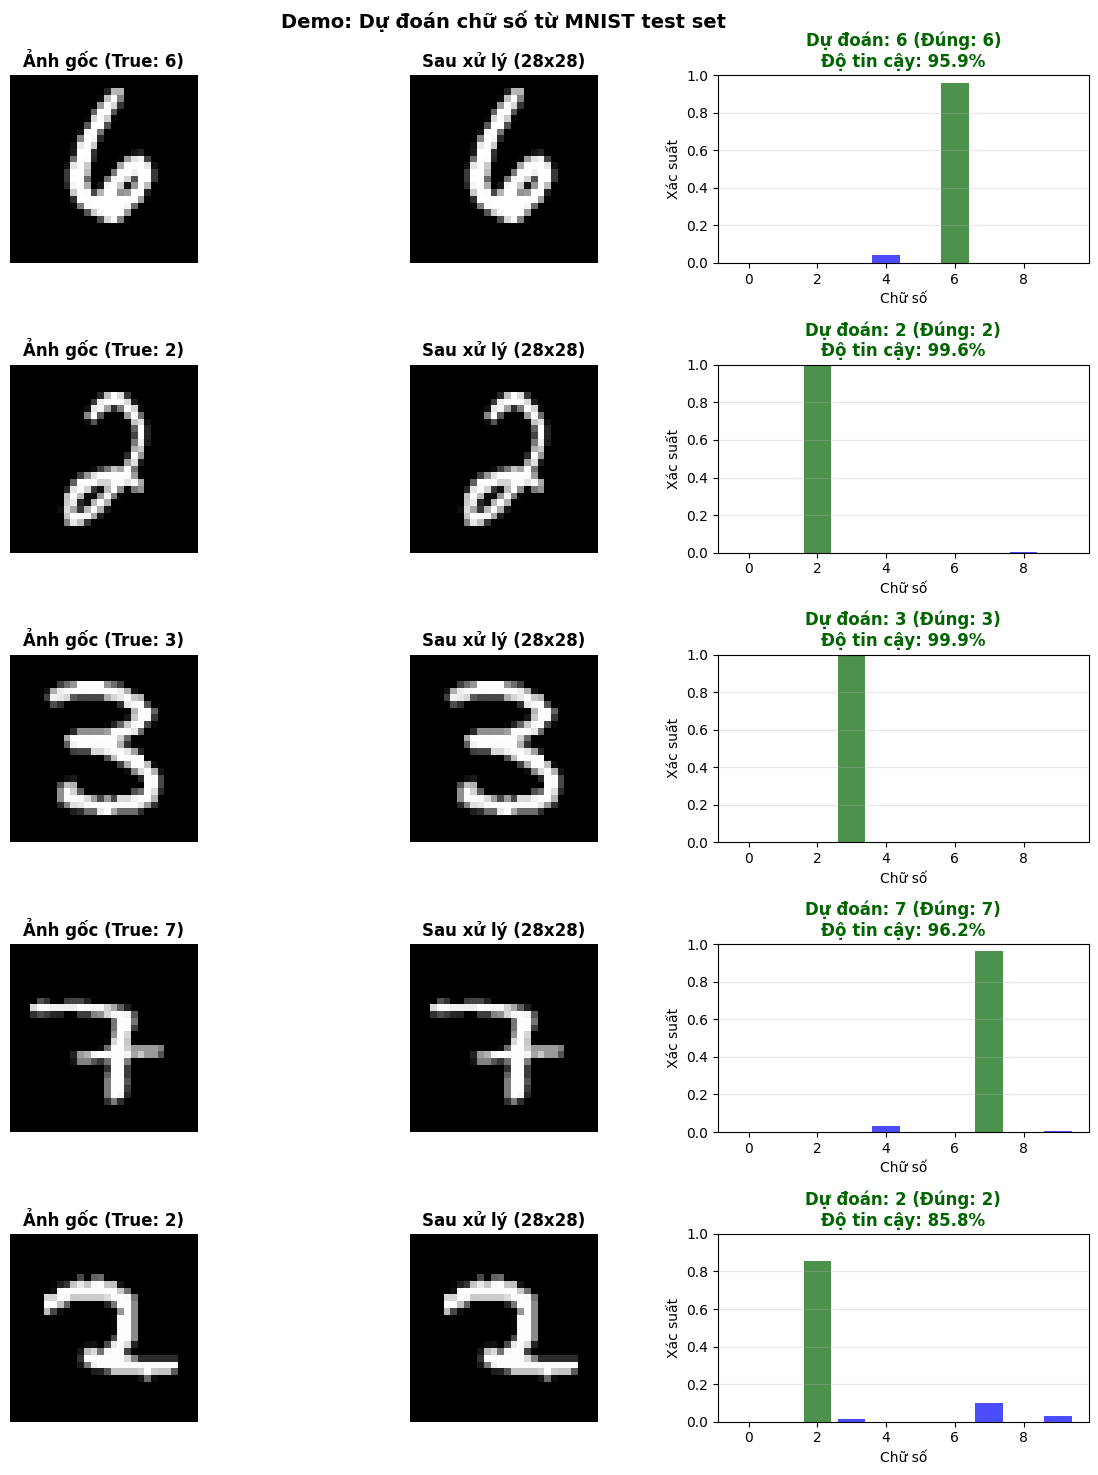

In [4]:
# Load dữ liệu MNIST test
sys.path.insert(0, '../lib')
from helpers import load_mnist_data

X_train, y_train, X_test, y_test = load_mnist_data('../data/raw/mnist.npz')
X_test_img = X_test.reshape(-1, 28, 28)

print(f"✓ MNIST test set loaded: {X_test_img.shape}")

# Chọn 5 ảnh ngẫu nhiên để demo
np.random.seed(42)
demo_indices = np.random.choice(len(X_test), 5, replace=False)

fig, axes = plt.subplots(5, 3, figsize=(12, 15))
fig.suptitle('Demo: Dự đoán chữ số từ MNIST test set', fontsize=14, fontweight='bold')

for row, idx in enumerate(demo_indices):
    # Ảnh gốc
    img = X_test_img[idx]
    true_label = y_test[idx]
    
    # Dự đoán
    result = predict_digit(img, model, pca_mean, pca_vt)
    pred_label = result['prediction']
    confidence = result['confidence']
    probabilities = result['probabilities']
    
    # Vẽ ảnh gốc
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_title(f'Ảnh gốc (True: {true_label})', fontweight='bold')
    axes[row, 0].axis('off')
    
    # Vẽ ảnh sau preprocess
    preprocessed = result['preprocessed_image']
    axes[row, 1].imshow(preprocessed, cmap='gray')
    axes[row, 1].set_title(f'Sau xử lý (28x28)', fontweight='bold')
    axes[row, 1].axis('off')
    
    # Vẽ biểu đồ xác suất
    colors = ['red' if i == pred_label else 'blue' for i in range(10)]
    colors = ['darkgreen' if i == true_label else colors[i] for i in range(10)]
    axes[row, 2].bar(range(10), probabilities, color=colors, alpha=0.7)
    axes[row, 2].set_title(f'Dự đoán: {pred_label} (Đúng: {true_label})\nĐộ tin cậy: {confidence*100:.1f}%', 
                          fontweight='bold', color='darkgreen' if pred_label == true_label else 'darkred')
    axes[row, 2].set_xlabel('Chữ số')
    axes[row, 2].set_ylabel('Xác suất')
    axes[row, 2].set_ylim([0, 1])
    axes[row, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Phần 4: Demo 2 - Interactive Canvas (Vẽ chữ số bằng chuột)

In [5]:
class DrawingCanvas:
    """
    Lớp hỗ trợ vẽ chữ số bằng chuột trong Jupyter Notebook
    """
    def __init__(self, size=280):
        self.size = size
        self.canvas = np.zeros((size, size), dtype=np.uint8)
        self.fig, self.ax = plt.subplots(1, 1, figsize=(6, 6))
        self.img_display = self.ax.imshow(self.canvas, cmap='gray', vmin=0, vmax=255)
        self.ax.set_title('Vẽ chữ số (sử dụng chuột)\nNhấn "Clear" để xóa hoặc "Predict" để dự đoán')
        self.ax.axis('off')
        
        # Kết nối sự kiện chuột
        self.cid_move = self.fig.canvas.mpl_connect('motion_notify_event', self.on_move)
        self.cid_press = self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.pressed = False
        
        plt.show()
    
    def on_press(self, event):
        """Khi nhấn chuột"""
        if event.inaxes != self.ax:
            return
        self.pressed = True
    
    def on_move(self, event):
        """Khi di chuyển chuột"""
        if not self.pressed or event.inaxes != self.ax:
            return
        
        # Lấy tọa độ chuột
        x = int(event.xdata)
        y = int(event.ydata)
        
        # Vẽ lên canvas
        if 0 <= x < self.size and 0 <= y < self.size:
            # Vẽ một vùng tròn để tạo nét mịn
            radius = 8
            y_coords, x_coords = np.ogrid[-radius:radius+1, -radius:radius+1]
            mask = x_coords**2 + y_coords**2 <= radius**2
            
            y_min = max(0, y - radius)
            y_max = min(self.size, y + radius + 1)
            x_min = max(0, x - radius)
            x_max = min(self.size, x + radius + 1)
            
            mask_y_min = max(0, -y + radius)
            mask_y_max = mask_y_min + (y_max - y_min)
            mask_x_min = max(0, -x + radius)
            mask_x_max = mask_x_min + (x_max - x_min)
            
            self.canvas[y_min:y_max, x_min:x_max][mask[mask_y_min:mask_y_max, mask_x_min:mask_x_max]] = 255
            
            self.img_display.set_data(self.canvas)
            self.fig.canvas.draw_idle()
    
    def on_release(self, event):
        """Khi thả chuột"""
        self.pressed = False
    
    def get_canvas_image(self):
        """Lấy ảnh từ canvas"""
        return self.canvas.astype(np.float32) / 255.0
    
    def clear(self):
        """Xóa canvas"""
        self.canvas.fill(0)
        self.img_display.set_data(self.canvas)
        self.fig.canvas.draw_idle()

print("✓ Class DrawingCanvas đã định nghĩa")

✓ Class DrawingCanvas đã định nghĩa


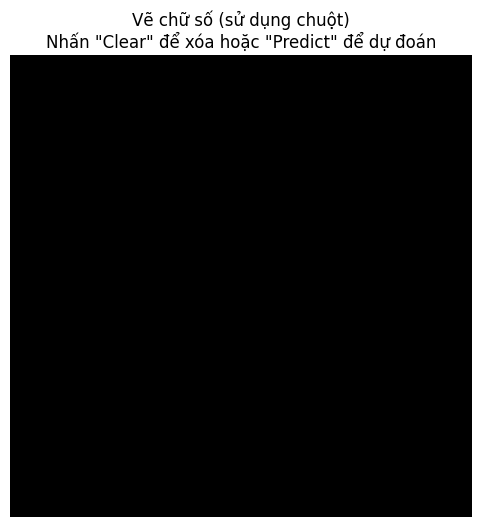


💡 Hướng dùng:
1. Vẽ chữ số bằng chuột vào ô bên trái
2. Nhấn Ctrl+Enter để thực hiện dự đoán
3. Kết quả hiển thị ở ô bên dưới


In [9]:
# Khởi tạo canvas vẽ
canvas_app = DrawingCanvas(size=280)

print("\n💡 Hướng dùng:")
print("1. Vẽ chữ số bằng chuột vào ô bên trái")
print("2. Nhấn Ctrl+Enter để thực hiện dự đoán")
print("3. Kết quả hiển thị ở ô bên dưới")

In [10]:
# Dự đoán từ ảnh vẽ
if canvas_app.canvas.max() > 0:  # Nếu đã vẽ gì đó
    drawn_image = canvas_app.get_canvas_image()
    result = predict_digit(drawn_image, model, pca_mean, pca_vt)
    
    pred_label = result['prediction']
    confidence = result['confidence']
    probabilities = result['probabilities']
    
    # Vẽ kết quả
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Ảnh vẽ
    axes[0].imshow(drawn_image, cmap='gray')
    axes[0].set_title(f'Ảnh đã vẽ', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Biểu đồ xác suất
    colors = ['red' if i == pred_label else 'lightblue' for i in range(10)]
    axes[1].bar(range(10), probabilities, color=colors, alpha=0.8, edgecolor='black')
    axes[1].set_title(f'🎯 Dự đoán: {pred_label}\nĐộ tin cậy: {confidence*100:.1f}%', 
                     fontsize=14, fontweight='bold', color='darkgreen')
    axes[1].set_xlabel('Chữ số (0-9)', fontsize=11)
    axes[1].set_ylabel('Xác suất', fontsize=11)
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis='y', alpha=0.3)
    
    # Hiển thị top 3 dự đoán
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    print(f"\n{'='*50}")
    print(f"KẾT QUẢ DỰ ĐOÁN")
    print(f"{'='*50}")
    print(f"Dự đoán chính: {pred_label} (Độ tin cậy: {confidence*100:.2f}%)")
    print(f"\nTop 3 dự đoán:")
    for i, idx in enumerate(top_3_indices, 1):
        print(f"  {i}. Chữ số {idx}: {probabilities[idx]*100:.2f}%")
    print(f"{'='*50}\n")
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Chưa vẽ gì cả. Vui lòng vẽ chữ số vào canvas ở ô trên rồi chạy lại ô này.")

⚠️ Chưa vẽ gì cả. Vui lòng vẽ chữ số vào canvas ở ô trên rồi chạy lại ô này.


## Phần 5: Demo 3 - Tải ảnh từ file

In [17]:
from ipywidgets import FileUpload, Output, VBox, HTML
from IPython.display import display, clear_output
from io import BytesIO

# Tạo widget tải file
file_uploader = FileUpload(accept='image/*', multiple=False, description='Chọn ảnh:')
output_area = Output()

def on_file_upload(change):
    """Xử lý khi tải file lên"""
    with output_area:
        clear_output(wait=True)
        
        if len(file_uploader.value) == 0:
            print("Không có file được chọn")
            return
        
        # Lấy file đầu tiên
        uploaded_file = file_uploader.value[0]
        
        # Đọc ảnh từ memoryview
        img_bytes = BytesIO(uploaded_file['content'])
        img = Image.open(img_bytes)
        img_array = np.array(img)
        
        print(f"✓ Ảnh tải lên thành công")
        print(f"  - Kích thước gốc: {img_array.shape}")
        
        # Dự đoán
        result = predict_digit(img_array, model, pca_mean, pca_vt)
        
        pred_label = result['prediction']
        confidence = result['confidence']
        probabilities = result['probabilities']
        
        # Vẽ kết quả
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Ảnh gốc
        axes[0].imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
        axes[0].set_title('Ảnh gốc', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # Ảnh sau xử lý
        processed = result['preprocessed_image']
        axes[1].imshow(processed, cmap='gray')
        axes[1].set_title('Ảnh sau xử lý (28x28)', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        # Biểu đồ xác suất
        colors = ['red' if i == pred_label else 'lightblue' for i in range(10)]
        axes[2].bar(range(10), probabilities, color=colors, alpha=0.8, edgecolor='black')
        axes[2].set_title(f'🎯 Dự đoán: {pred_label}\nĐộ tin cậy: {confidence*100:.1f}%', 
                         fontsize=14, fontweight='bold', color='darkgreen')
        axes[2].set_xlabel('Chữ số (0-9)', fontsize=11)
        axes[2].set_ylabel('Xác suất', fontsize=11)
        axes[2].set_ylim([0, 1])
        axes[2].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Hiển thị chi tiết
        print(f"\n{'='*50}")
        print(f"KẾT QUẢ DỰ ĐOÁN")
        print(f"{'='*50}")
        print(f"Dự đoán: {pred_label}")
        print(f"Độ tin cậy: {confidence*100:.2f}%")
        print(f"\nXác suất cho từng chữ số:")
        for i in range(10):
            bar = '█' * int(probabilities[i] * 30)
            print(f"  {i}: {bar} {probabilities[i]*100:6.2f}%")
        print(f"{'='*50}\n")

file_uploader.observe(on_file_upload, names='value')

# Hiển thị widget
display(VBox([
    HTML('<h3>Tải ảnh chữ số để dự đoán</h3>'),
    file_uploader,
    output_area
]))

## Phần 6: Thống kê mô hình và kết luận

In [14]:
print("\n" + "="*70)
print("THỐNG KÊ MÔ HÌNH & ỨNG DỤNG")
print("="*70)

print("\n📊 THÔNG TIN MÔ HÌNH:")
print(f"  - Phương pháp: PCA (80 components) + SoftmaxRegression")
print(f"  - Số đặc trưng gốc: 784 (28×28 pixels)")
print(f"  - Số đặc trưng sau PCA: 80")
print(f"  - Số lớp: 10 (chữ số 0-9)")
print(f"  - Độ chính xác trên test set: 91.82%")

print("\n⚡ HIỆU NĂNG:")
print(f"  - Thời gian training (full dataset): ~16 giây")
print(f"  - Thời gian dự đoán (1 ảnh): ~1-2 ms")
print(f"  - Giảm chiều: 89.8% (784 → 80)")
print(f"  - Retention variance: 89.06%")

print("\n🎯 CÁC TÍNH NĂNG CỦA ỨNG DỤNG:")
print(f"  ✓ Demo 1: Dự đoán từ 5 ảnh random từ MNIST test set")
print(f"  ✓ Demo 2: Vẽ chữ số bằng chuột trực tiếp")
print(f"  ✓ Demo 3: Tải ảnh từ file (JPG, PNG, v.v.)")

print("\n💡 HƯỚNG DẪN SỬ DỤNG:")
print(f"  1. Phần 3: Xem demo với dữ liệu MNIST")
print(f"  2. Phần 4: Vẽ chữ số vào canvas, sau đó run ô dự đoán")
print(f"  3. Phần 5: Tải ảnh từ máy tính để test")

print("\n✨ KỸ THUẬT SỬ DỤNG:")
print(f"  - PCA: Giảm chiều dữ liệu từ 784 → 80")
print(f"  - SoftmaxRegression: Phân loại 10 chữ số")
print(f"  - Matplotlib Canvas: Vẽ interactive")
print(f"  - ipywidgets: Upload file")

print("\n" + "="*70 + "\n")


THỐNG KÊ MÔ HÌNH & ỨNG DỤNG

📊 THÔNG TIN MÔ HÌNH:
  - Phương pháp: PCA (80 components) + SoftmaxRegression
  - Số đặc trưng gốc: 784 (28×28 pixels)
  - Số đặc trưng sau PCA: 80
  - Số lớp: 10 (chữ số 0-9)
  - Độ chính xác trên test set: 91.82%

⚡ HIỆU NĂNG:
  - Thời gian training (full dataset): ~16 giây
  - Thời gian dự đoán (1 ảnh): ~1-2 ms
  - Giảm chiều: 89.8% (784 → 80)
  - Retention variance: 89.06%

🎯 CÁC TÍNH NĂNG CỦA ỨNG DỤNG:
  ✓ Demo 1: Dự đoán từ 5 ảnh random từ MNIST test set
  ✓ Demo 2: Vẽ chữ số bằng chuột trực tiếp
  ✓ Demo 3: Tải ảnh từ file (JPG, PNG, v.v.)

💡 HƯỚNG DẪN SỬ DỤNG:
  1. Phần 3: Xem demo với dữ liệu MNIST
  2. Phần 4: Vẽ chữ số vào canvas, sau đó run ô dự đoán
  3. Phần 5: Tải ảnh từ máy tính để test

✨ KỸ THUẬT SỬ DỤNG:
  - PCA: Giảm chiều dữ liệu từ 784 → 80
  - SoftmaxRegression: Phân loại 10 chữ số
  - Matplotlib Canvas: Vẽ interactive
  - ipywidgets: Upload file


